# AIN433: Computer Vision Lab - Spring 2025
## **Assignment 1**  
#### Instructor: Nazli Ikizler-Cinbis
#### TA: Sibel Kapan

**Student Name**: Süleyman Yolcu

**Student ID**: 2210765016


# =============================================================================
#           IMPORT LIBRARIES & CONFIGURATIONS
# =============================================================================

In [3]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os
import glob
import random
import math
from scipy.ndimage import maximum_filter

# Use this in Jupyter notebooks to display plots inline.
%matplotlib inline

# =============================================================================
#           IMAGE PREPROCESSING & EDGE DETECTION
# =============================================================================

In [5]:
def preprocess_image(image_path):
    """
    Load an image, resize it to 1024x1024 pixels, and convert to grayscale.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not load image from " + image_path)
    image = cv2.resize(image, (1024, 1024))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

def detect_edges(gray, debug=False):
    """
    Apply Gaussian blur and Canny edge detection on a grayscale image.
    Optionally display the edge map.
    """
    # Apply a strong Gaussian blur to reduce noise.
    blurred = cv2.GaussianBlur(gray, (17, 17), 0)
    # Use Canny edge detector.
    edges = cv2.Canny(blurred, 30, 90)
    
    if debug:
        print("Canny Edges")
        plt.figure(figsize=(8, 8))
        plt.imshow(edges, cmap='gray')
        #plt.title("Canny Edges")
        plt.axis("off")
        plt.show()
    return edges

# =============================================================================
#           HOUGH TRANSFORM & LINE EXTRACTION
# =============================================================================

In [7]:
def hough_transform(edges, rho_res=1, theta_res=np.pi/180):
    """
    Compute the Hough transform of the edge image to detect lines.
    Returns the accumulator, theta values, and rho values.
    """
    height, width = edges.shape
    diag_len = int(np.ceil(np.sqrt(width**2 + height**2)))
    rhos = np.arange(-diag_len, diag_len + 1, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.float64)
    
    # Get indices of non-zero (edge) pixels.
    y_idxs, x_idxs = np.nonzero(edges)
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    
    # For each theta, compute the corresponding rho values and update the accumulator.
    for t_idx in range(len(thetas)):
        rho_vals = x_idxs * cos_t[t_idx] + y_idxs * sin_t[t_idx]
        rho_indices = np.round(rho_vals).astype(int) + diag_len
        valid_mask = (rho_indices >= 0) & (rho_indices < accumulator.shape[0])
        rho_indices = rho_indices[valid_mask]
        counts = np.bincount(rho_indices, minlength=accumulator.shape[0])
        accumulator[:, t_idx] += counts
        
    return accumulator, thetas, rhos

def get_hough_peaks(accumulator, num_peaks=10, threshold=50, nhood_size=10):
    """
    Identify peaks in the Hough accumulator array.
    Returns a list of (rho_index, theta_index) tuples for the strongest peaks.
    """
    acc_copy = accumulator.copy()
    peaks = []
    for _ in range(num_peaks):
        idx = np.argmax(acc_copy)
        rho_idx, theta_idx = np.unravel_index(idx, acc_copy.shape)
        if acc_copy[rho_idx, theta_idx] < threshold:
            break  # Stop if the maximum value is below the threshold.
        peaks.append((rho_idx, theta_idx))
        # Zero out a neighborhood around the peak to avoid selecting nearby peaks.
        rho_min = max(rho_idx - nhood_size // 2, 0)
        rho_max = min(rho_idx + nhood_size // 2 + 1, acc_copy.shape[0])
        theta_min = max(theta_idx - nhood_size // 2, 0)
        theta_max = min(theta_idx + nhood_size // 2 + 1, acc_copy.shape[1])
        acc_copy[rho_min:rho_max, theta_min:theta_max] = 0
    return peaks

def extract_line_points(edges, rho, theta, dist_threshold=2):
    """
    Extract points from edge image that lie close to a given line (rho, theta).
    """
    # Get indices of edge pixels.
    y_idxs, x_idxs = np.nonzero(edges)
    points = []
    for x, y in zip(x_idxs, y_idxs):
        # Distance from point (x, y) to the line: |x*cos(theta) + y*sin(theta) - rho|
        if abs(x * np.cos(theta) + y * np.sin(theta) - rho) < dist_threshold:
            points.append((x, y))
    return np.array(points)

# =============================================================================
#                            RANSAC
# =============================================================================

In [9]:
def ransac_line(points, iterations=100, distance_threshold=2):
    """
    Use RANSAC to robustly estimate a line model from given points.
    Returns line parameters (a, b, c) for the line equation: a*x + b*y + c = 0.
    """
    best_line = None
    best_inlier_count = 0
    best_inliers = None
    
    if len(points) < 2:
        return None
    
    for i in range(iterations):
        # Randomly sample two distinct points.
        idx = np.random.choice(len(points), 2, replace=False)
        p1, p2 = points[idx[0]], points[idx[1]]
        # Compute line parameters in ax + by + c = 0 form.
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        c = p2[0]*p1[1] - p1[0]*p2[1]
        # Compute distance of all points from the line.
        denom = np.sqrt(a**2 + b**2)
        distances = np.abs(a * points[:,0] + b * points[:,1] + c) / denom
        inliers = points[distances < distance_threshold]
        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_line = (a, b, c)
            best_inliers = inliers

    # Refine line parameters using all inliers with cv2.fitLine.
    if best_inliers is not None and len(best_inliers) > 0:
        [vx, vy, x0, y0] = cv2.fitLine(best_inliers, cv2.DIST_L2, 0, 0.01, 0.01)
        # Convert the fit-line (vector form) to the normal form.
        a = -vy
        b = vx
        c = -(a * x0 + b * y0)
        best_line = (a[0], b[0], c[0])
    return best_line

def refine_lines(peaks, thetas, rhos, edges, dist_threshold=2):
    """
    Refine each detected line using RANSAC.
    For each peak in the Hough space, extract edge points and estimate a robust line.
    """
    refined_lines = []
    for (rho_idx, theta_idx) in peaks:
        rho_val = rhos[rho_idx]
        theta_val = thetas[theta_idx]
        pts = extract_line_points(edges, rho_val, theta_val, dist_threshold)
        line = ransac_line(pts)
        if line is not None:
            refined_lines.append(line)
    return refined_lines

# =============================================================================
#           DOCUMENT EDGE & CORNER DETECTION
# =============================================================================

In [11]:
def select_document_edges(candidate_lines):
    """
    Group candidate lines into horizontal and vertical based on their orientation
    and select the extreme ones (top, bottom, left, right) as document edges.
    """
    horizontal_lines = []
    vertical_lines = []
    for line in candidate_lines:
        a, b, c = line
        # Compute orientation angle using arctan2.
        angle = abs(np.arctan2(a, b))  # in radians
        # Near-horizontal lines: angle is small.
        if angle < np.pi / 4:
            if b != 0:  # Avoid division by zero.
                y_int = -c / b
                horizontal_lines.append((line, y_int))
        else:
            if a != 0:
                x_int = -c / a
                vertical_lines.append((line, x_int))
    
    # Fallback: if not enough lines are detected, return all candidate lines.
    if len(horizontal_lines) < 2 or len(vertical_lines) < 2:
        return candidate_lines
    
    # Sort horizontal lines by y-intercept to pick the top and bottom edges.
    horizontal_lines.sort(key=lambda x: x[1])
    top_line = horizontal_lines[0][0]
    bottom_line = horizontal_lines[-1][0]
    
    # Sort vertical lines by x-intercept to pick the left and right edges.
    vertical_lines.sort(key=lambda x: x[1])
    left_line = vertical_lines[0][0]
    right_line = vertical_lines[-1][0]
    
    return [top_line, right_line, bottom_line, left_line]

def line_intersection(line1, line2):
    """
    Compute the intersection point of two lines given in ax + by + c = 0 form.
    Returns (x, y) or None if lines are parallel.
    """
    a1, b1, c1 = line1
    a2, b2, c2 = line2
    det = a1 * b2 - a2 * b1
    if np.abs(det) < 1e-10:
        return None
    x = (b2 * (-c1) - b1 * (-c2)) / det
    y = (a1 * (-c2) - a2 * (-c1)) / det
    return (x, y)

def get_quadrilateral_from_lines(lines):
    """
    Compute intersections of lines to form a quadrilateral.
    Order the intersection points as: top-left, top-right, bottom-right, bottom-left.
    """
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            pt = line_intersection(lines[i], lines[j])
            if pt is not None:
                intersections.append(pt)
    if len(intersections) != 4:
        print("Warning: Expected 4 intersections, got", len(intersections))
        return None

    pts = np.array(intersections)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).flatten()
    top_left = pts[np.argmin(s)]
    bottom_right = pts[np.argmax(s)]
    top_right = pts[np.argmin(diff)]
    bottom_left = pts[np.argmax(diff)]
    
    return np.array([top_left, top_right, bottom_right, bottom_left])

def ransac_quadrilateral_from_intersections(candidate_lines, image, iterations=1000, threshold=10, debug=False):
    """
    Estimate document corners by selecting four robust document edge lines,
    computing their intersections and forming a quadrilateral.
    """
    selected_lines = select_document_edges(candidate_lines)
    if len(selected_lines) != 4:
        return None
    top_line, right_line, bottom_line, left_line = selected_lines
    
    # Compute intersections for the four corners.
    tl = line_intersection(top_line, left_line)
    tr = line_intersection(top_line, right_line)
    br = line_intersection(bottom_line, right_line)
    bl = line_intersection(bottom_line, left_line)
    
    if tl is None or tr is None or br is None or bl is None:
        print("One or more intersections could not be computed.")
        return None
    
    quad = np.array([tl, tr, br, bl])
    
    if debug:
        debug_img_lines = image.copy()
        # Convert corners to integer coordinates.
        pts_int = np.array([[int(pt[0]), int(pt[1])] for pt in quad])
        # Draw lines connecting the corners.
        cv2.line(debug_img_lines, tuple(pts_int[0]), tuple(pts_int[1]), (0, 255, 0), 2)
        cv2.line(debug_img_lines, tuple(pts_int[1]), tuple(pts_int[2]), (0, 255, 0), 2)
        cv2.line(debug_img_lines, tuple(pts_int[2]), tuple(pts_int[3]), (0, 255, 0), 2)
        cv2.line(debug_img_lines, tuple(pts_int[3]), tuple(pts_int[0]), (0, 255, 0), 2)
        
        print("RANSAC Lines")
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(debug_img_lines, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        
        debug_img_corners = image.copy()
        # Draw circles at the computed corner positions.
        for pt in quad:
            cv2.circle(debug_img_corners, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(debug_img_corners, cv2.COLOR_BGR2RGB))
        print("Detected Document Corners")
        plt.axis("off")
        plt.show()
    
    return quad

# =============================================================================
#           PERSPECTIVE TRANSFORMATION
# =============================================================================

In [13]:
def get_perspective_transform(src, dst):
    """
    Compute the 3x3 perspective transform (homography) matrix that maps
    the four source points to the destination points.
    """
    src = np.asarray(src, dtype=np.float64)
    dst = np.asarray(dst, dtype=np.float64)
    
    # Build a system of 8 equations for the 8 unknowns.
    A = []
    b = []
    for (x, y), (u, v) in zip(src, dst):
        A.append([x, y, 1, 0, 0, 0, -u * x, -u * y])
        b.append(u)
        A.append([0, 0, 0, x, y, 1, -v * x, -v * y])
        b.append(v)
    A = np.array(A)
    b = np.array(b)
    
    # Solve for the homography parameters.
    h = np.linalg.solve(A, b)
    
    # Form the 3x3 homography matrix by appending 1.
    H = np.append(h, 1).reshape((3, 3))
    return H

def warp_perspective(image, M, output_size):
    """
    Warp the input image using the provided perspective transform matrix.
    Implements bilinear interpolation for smooth results.
    """
    width, height = output_size  # output_size is (width, height)
    
    # Compute the inverse transform for backward mapping.
    M_inv = np.linalg.inv(M)
    
    # Generate a grid of destination (u, v) coordinates.
    u_coords, v_coords = np.meshgrid(np.arange(width), np.arange(height))
    ones = np.ones_like(u_coords)
    dst_coords = np.stack([u_coords, v_coords, ones], axis=0).reshape(3, -1)
    
    # Map destination coordinates back to source coordinates.
    src_coords = M_inv @ dst_coords
    src_coords /= src_coords[2, :]  # Normalize homogeneous coordinates
    
    # Reshape to 2D maps for x and y.
    src_x = src_coords[0, :].reshape((height, width))
    src_y = src_coords[1, :].reshape((height, width))
    
    # Prepare the output image.
    if image.ndim == 3:
        channels = image.shape[2]
        warped = np.zeros((height, width, channels), dtype=image.dtype)
    else:
        warped = np.zeros((height, width), dtype=image.dtype)
    
    # Ensure coordinates are within the image bounds.
    src_x_clipped = np.clip(src_x, 0, image.shape[1] - 1)
    src_y_clipped = np.clip(src_y, 0, image.shape[0] - 1)
    
    # Compute indices for bilinear interpolation.
    x0 = np.floor(src_x_clipped).astype(np.int32)
    x1 = np.clip(x0 + 1, 0, image.shape[1] - 1)
    y0 = np.floor(src_y_clipped).astype(np.int32)
    y1 = np.clip(y0 + 1, 0, image.shape[0] - 1)
    
    # Compute interpolation weights.
    wa = (x1 - src_x_clipped) * (y1 - src_y_clipped)
    wb = (src_x_clipped - x0) * (y1 - src_y_clipped)
    wc = (x1 - src_x_clipped) * (src_y_clipped - y0)
    wd = (src_x_clipped - x0) * (src_y_clipped - y0)
    
    # Perform bilinear interpolation.
    if image.ndim == 3:
        for c in range(image.shape[2]):
            warped[..., c] = (wa * image[y0, x0, c] +
                              wb * image[y0, x1, c] +
                              wc * image[y1, x0, c] +
                              wd * image[y1, x1, c])
    else:
        warped = (wa * image[y0, x0] +
                  wb * image[y0, x1] +
                  wc * image[y1, x0] +
                  wd * image[y1, x1])
    
    return warped

def perspective_transform(image, quad):
    """
    Apply a perspective transformation to the input image using the given quadrilateral.
    Returns the warped (dewarped) image.
    """
    quad = quad.astype("float32")
    
    # Compute the width of the new image.
    widthA = np.linalg.norm(quad[2] - quad[3])
    widthB = np.linalg.norm(quad[1] - quad[0])
    maxWidth = int(max(widthA, widthB))
    
    # Compute the height of the new image.
    heightA = np.linalg.norm(quad[1] - quad[2])
    heightB = np.linalg.norm(quad[0] - quad[3])
    maxHeight = int(max(heightA, heightB))
    
    # Define destination points for the perspective transform.
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    
    # Compute the perspective transform matrix and apply it.
    M = get_perspective_transform(quad, dst)
    warped = warp_perspective(image, M, (maxWidth, maxHeight))
    
    return warped

# =============================================================================
#           EVALUATION METRICS (SSIM)
# =============================================================================

In [15]:
def evaluate_ssim(ground_truth, test_image, convert_gray=True, debug=True):
    """
    Evaluate the Structural Similarity Index (SSIM) between two images and
    display them side by side. If dimensions differ, the test image is resized.
    """
    # Convert images to grayscale if required.
    if convert_gray:
        gt_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY) if len(ground_truth.shape) == 3 else ground_truth.copy()
        test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) if len(test_image.shape) == 3 else test_image.copy()
    else:
        gt_gray = ground_truth
        test_gray = test_image

    # Resize test image if dimensions differ.
    if gt_gray.shape != test_gray.shape:
        test_gray = cv2.resize(test_gray, (gt_gray.shape[1], gt_gray.shape[0]))
        display_test = cv2.resize(test_image, (ground_truth.shape[1], ground_truth.shape[0]))
    else:
        display_test = test_image

    # Compute the SSIM score.
    score, _ = ssim(gt_gray, test_gray, full=True)

    if debug:
        # Display ground truth image
        print("Ground Truth Image")
        plt.figure(figsize=(8, 8))
        if len(ground_truth.shape) == 3:
            plt.imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(ground_truth, cmap='gray')
        plt.axis("off")
        plt.show()
    
        # Display warped image
        print("Warped Image")
        plt.figure(figsize=(8, 8))
        if len(display_test.shape) == 3:
            plt.imshow(cv2.cvtColor(display_test, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(display_test, cmap='gray')
        plt.axis("off")
        plt.show()
    
        print(f"SSIM Score: {score:.2f}")
    return score


# =============================================================================
#           MAIN DOCUMENT PROCESSING FUNCTION
# =============================================================================

In [17]:
def process_document(distorted_img_path, ground_truth_img_path=None, debug=False):
    """
    Process a single document image by:
      1. Preprocessing and edge detection.
      2. Detecting lines using the Hough transform.
      3. Refining lines using RANSAC.
      4. Estimating document corners.
      5. Applying perspective transformation.
      6. Optionally evaluating SSIM against a ground truth image.
    
    Returns the warped image and the SSIM score (if ground truth provided).
    """
    # Preprocess the image and detect edges.
    image, gray = preprocess_image(distorted_img_path)
    edges = detect_edges(gray, debug=debug)

        
    # Apply Hough Transform to detect lines.
    accumulator, thetas, rhos = hough_transform(edges)
    peaks = get_hough_peaks(accumulator, num_peaks=10, threshold=50, nhood_size=10)
    
    if debug:
        # Visualize detected Hough lines.
        hough_img = image.copy()
        for rho_idx, theta_idx in peaks:
            rho_val = rhos[rho_idx]
            theta_val = thetas[theta_idx]
            a = np.cos(theta_val)
            b = np.sin(theta_val)
            x0 = a * rho_val
            y0 = b * rho_val
            pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
            pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
            cv2.line(hough_img, pt1, pt2, (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
        print("Hough Transform Lines")
        plt.axis("off")
        plt.show()
    
    # Refine the detected lines using RANSAC.
    candidate_lines = refine_lines(peaks, thetas, rhos, edges, dist_threshold=2)
    
    # Estimate document corners from line intersections.
    corners = ransac_quadrilateral_from_intersections(candidate_lines, image, iterations=1000, threshold=10, debug=debug)
    if corners is None:
        return None, None
    
    # Apply perspective transformation to dewarp the document.
    warped = perspective_transform(image, corners)

        
    # Evaluate SSIM if a ground-truth image is provided.
    ssim_score = None
    if ground_truth_img_path is not None and warped is not None:
        ground_truth = cv2.imread(ground_truth_img_path)
        if ground_truth is None:
            print("Could not load ground truth image from", ground_truth_img_path)
        else:
            ssim_score = evaluate_ssim(ground_truth, warped, debug=debug)
            
    if debug:
        image_rs = cv2.resize(image, (ground_truth.shape[1], ground_truth.shape[0]))
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(image_rs, cv2.COLOR_BGR2RGB))
        print("Original Image")
        plt.axis("off")
        plt.show()

    
    return warped, ssim_score

# =============================================================================
#           SINGLE IMAGE PROCESSING EXAMPLE
# =============================================================================

Canny Edges


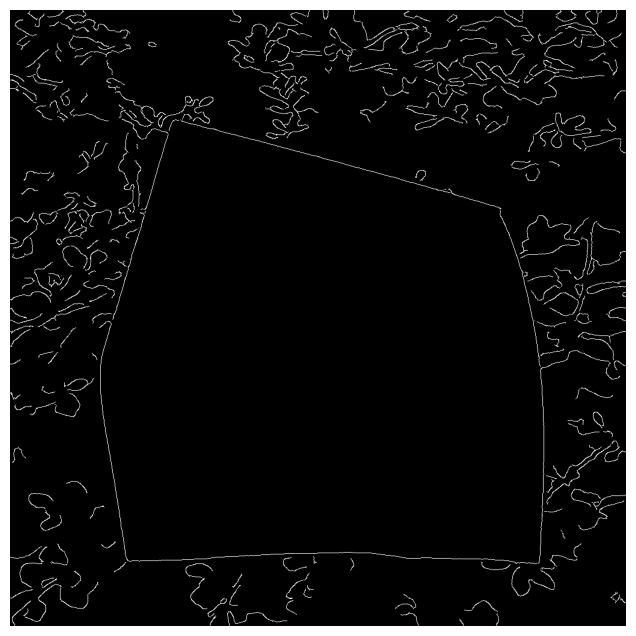

Hough Transform Lines


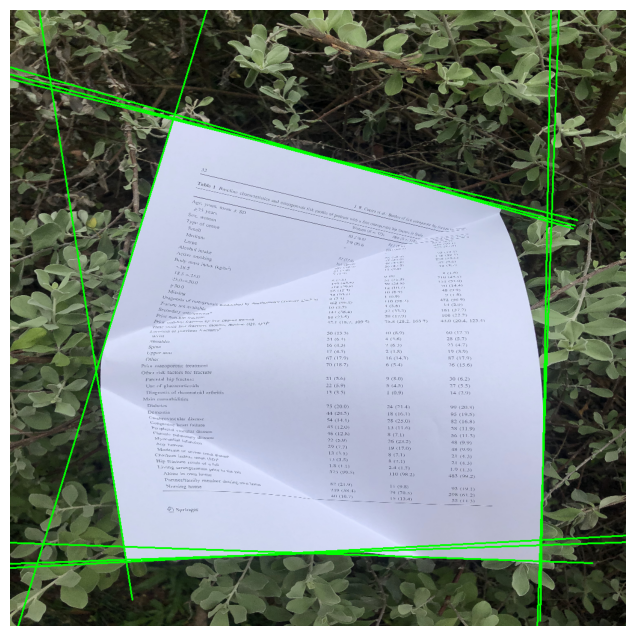

RANSAC Lines


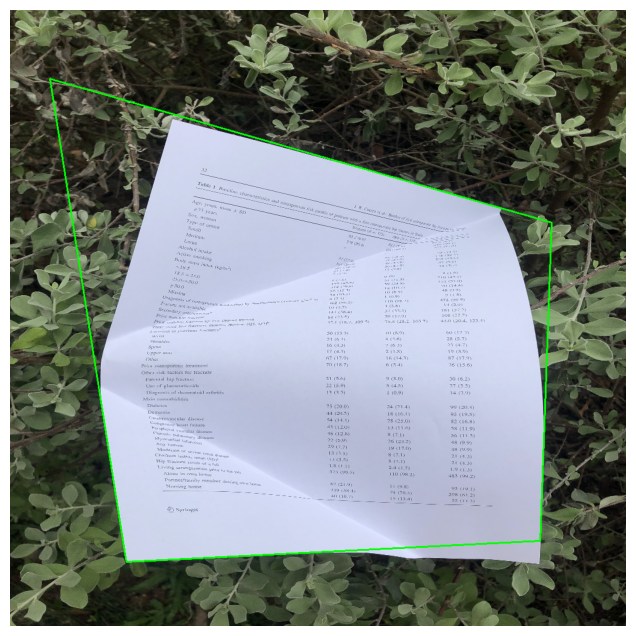

Detected Document Corners


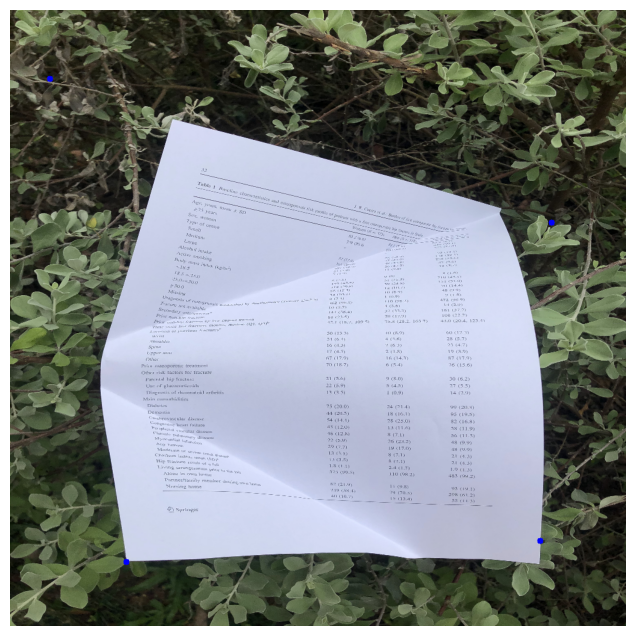

Ground Truth Image


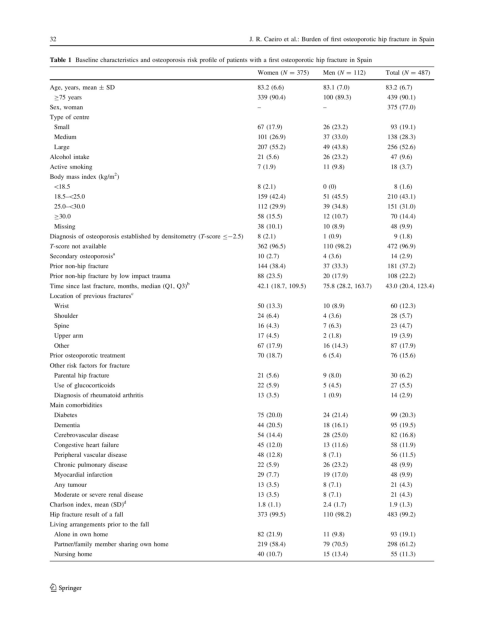

Warped Image


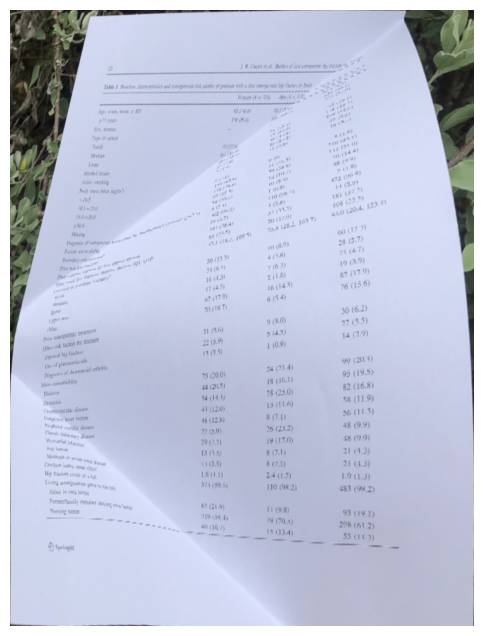

SSIM Score: 0.75
Original Image


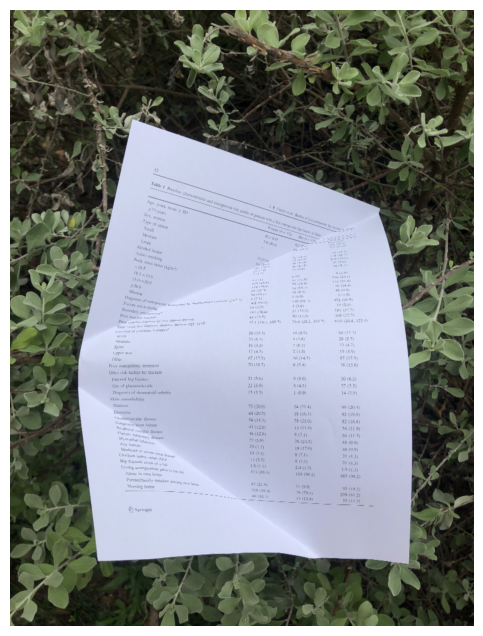

In [19]:
single_distorted_path = "Desktop/WarpDoc/distorted/fold/0005.jpg"
single_ground_truth_path = "Desktop/WarpDoc/digital/fold/0005.jpg"
warped_img, ssim_val = process_document(single_distorted_path, single_ground_truth_path, debug=True)

# =============================================================================
#           BATCH PROCESSING FOR MULTIPLE DOCUMENTS
# =============================================================================

In [21]:
def process_folder(distorted_folder, digital_folder, num_samples=50, category="unknown", debug=False):
    """
    Process all images in a given folder, compute their warped outputs,
    and calculate SSIM scores against ground-truth images.
    
    Returns a list of dictionaries containing processing results.
    """
    distorted_images = glob.glob(os.path.join(distorted_folder, "*.jpg"))
    if len(distorted_images) == 0:
        print("No images found in", distorted_folder)
        return []
    
    sample_images = distorted_images[:min(num_samples, len(distorted_images))]
    results = []
    for img_path in sample_images:
        base_name = os.path.basename(img_path)
        gt_path = os.path.join(digital_folder, base_name)
        warped, ssim_val = process_document(img_path, gt_path, debug=debug)
        results.append({
            "distorted": img_path,
            "ground_truth": gt_path,
            "warped": warped,
            "ssim": ssim_val,
            "category": category
        })
    
    # Compute and print SSIM metrics if available.
    valid_results = [r for r in results if r["ssim"] is not None]
    if valid_results:
        ssim_scores = [(r["ssim"], os.path.splitext(os.path.basename(r["distorted"]))[0]) for r in valid_results]
        avg_ssim = sum(score for score, doc in ssim_scores) / len(ssim_scores)
        best_two = sorted(ssim_scores, key=lambda x: x[0], reverse=True)[:2]
        worst_two = sorted(ssim_scores, key=lambda x: x[0])[:2]
        
        print(f"Category: {category}")
        print(f"Average SSIM: {avg_ssim:.4f}")
        print("Best 2 SSIM scores:")
        for score, doc in best_two:
            print(f"  Document {doc} - SSIM: {score:.4f}")
        print("Worst 2 SSIM scores:")
        for score, doc in worst_two:
            print(f"  Document {doc} - SSIM: {score:.4f}")
    else:
        print(f"No valid SSIM scores computed for category {category}")
    
    return results

# Process multiple document categories.
categories = ["curved", "fold", "incomplete", "perspective", "random", "rotate"]
base_distorted = "Desktop/WarpDoc/distorted"
base_digital = "Desktop/WarpDoc/digital"
all_results = {}
for cat in categories:
    print(f"\nProcessing category: {cat}")
    distorted_folder = os.path.join(base_distorted, cat)
    digital_folder = os.path.join(base_digital, cat)
    results = process_folder(distorted_folder, digital_folder, num_samples=50, category=cat, debug=False)
    all_results[cat] = results


Processing category: curved
Category: curved
Average SSIM: 0.4760
Best 2 SSIM scores:
  Document 0002 - SSIM: 0.8805
  Document 0037 - SSIM: 0.7644
Worst 2 SSIM scores:
  Document 0024 - SSIM: 0.1318
  Document 0005 - SSIM: 0.1441

Processing category: fold
Category: fold
Average SSIM: 0.5155
Best 2 SSIM scores:
  Document 0005 - SSIM: 0.7521
  Document 0028 - SSIM: 0.7453
Worst 2 SSIM scores:
  Document 0034 - SSIM: 0.1032
  Document 0048 - SSIM: 0.1581

Processing category: incomplete
Category: incomplete
Average SSIM: 0.4785
Best 2 SSIM scores:
  Document 0001 - SSIM: 0.7130
  Document 0021 - SSIM: 0.6715
Worst 2 SSIM scores:
  Document 0025 - SSIM: 0.0723
  Document 0020 - SSIM: 0.1216

Processing category: perspective
Category: perspective
Average SSIM: 0.5489
Best 2 SSIM scores:
  Document 0049 - SSIM: 0.8050
  Document 0008 - SSIM: 0.7545
Worst 2 SSIM scores:
  Document 0041 - SSIM: 0.2049
  Document 0025 - SSIM: 0.2433

Processing category: random
Category: random
Average SSIM

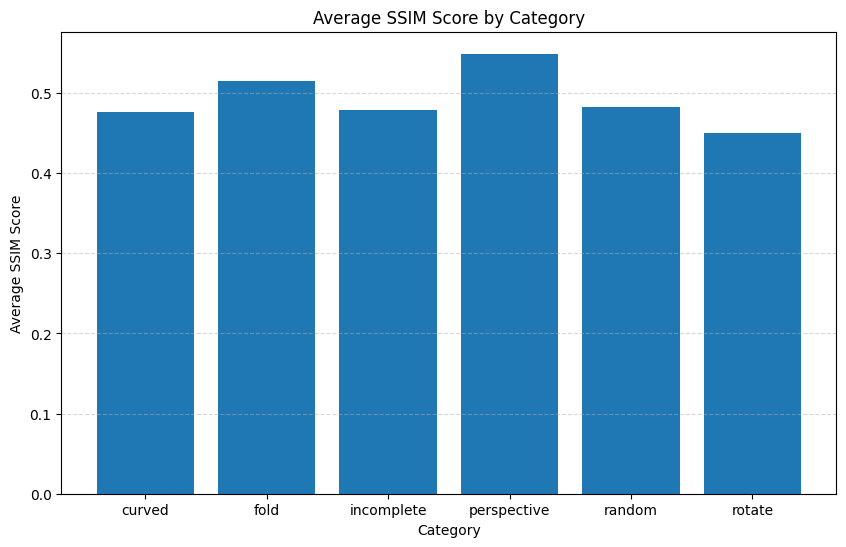

In [22]:
def plot_ssim_comparison(all_results):
    # Extract the list of categories.
    categories = list(all_results.keys())
    
    # Prepare the data: extract SSIM scores (ignoring any None values).
    ssim_data = []
    for cat in categories:
        scores = [result["ssim"] for result in all_results[cat] if result["ssim"] is not None]
        ssim_data.append(scores)
    
    avg_ssim = []
    for scores in ssim_data:
        if scores:
            avg_ssim.append(sum(scores) / len(scores))
        else:
            avg_ssim.append(0)
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, avg_ssim)
    plt.xlabel("Category")
    plt.ylabel("Average SSIM Score")
    plt.title("Average SSIM Score by Category")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Call the plotting function using the previously computed all_results
plot_ssim_comparison(all_results)
